Loading dataset
This may take a while...
Done training model. 
Diagnostic plot: leading coeffs and scatters across wavelength.
Diagnostic plot: histogram of the red chi squareds of the fit
Saved as modelfit_chisqs.png
Inferring Labels


C:\Users\Jude\anaconda3\lib\site-packages\scipy\stats\_stats_mstats_common.py:130: RuntimeWarning: invalid value encountered in double_scalars
  slope = r_num / ssxm
C:\Users\Jude\anaconda3\lib\site-packages\scipy\stats\_stats_mstats_common.py:140: RuntimeWarning: invalid value encountered in sqrt
  t = r * np.sqrt(df / ((1.0 - r + TINY)*(1.0 + r + TINY)))
C:\Users\Jude\anaconda3\lib\site-packages\scipy\stats\_stats_mstats_common.py:142: RuntimeWarning: invalid value encountered in double_scalars
  sterrest = np.sqrt((1 - r**2) * ssym / ssxm / df)


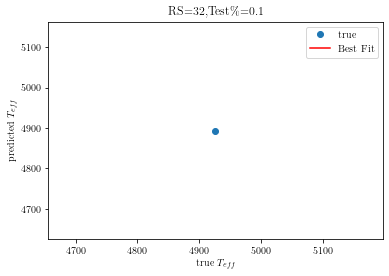

C:\Users\Jude\anaconda3\lib\site-packages\scipy\stats\_stats_mstats_common.py:130: RuntimeWarning: invalid value encountered in double_scalars
  slope = r_num / ssxm
C:\Users\Jude\anaconda3\lib\site-packages\scipy\stats\_stats_mstats_common.py:140: RuntimeWarning: invalid value encountered in sqrt
  t = r * np.sqrt(df / ((1.0 - r + TINY)*(1.0 + r + TINY)))
C:\Users\Jude\anaconda3\lib\site-packages\scipy\stats\_stats_mstats_common.py:142: RuntimeWarning: invalid value encountered in double_scalars
  sterrest = np.sqrt((1 - r**2) * ssym / ssxm / df)


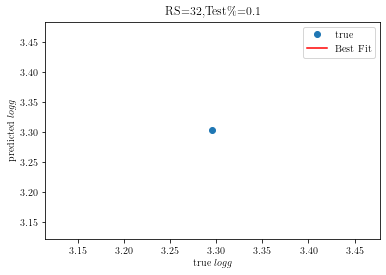

C:\Users\Jude\anaconda3\lib\site-packages\scipy\stats\_stats_mstats_common.py:130: RuntimeWarning: invalid value encountered in double_scalars
  slope = r_num / ssxm
C:\Users\Jude\anaconda3\lib\site-packages\scipy\stats\_stats_mstats_common.py:140: RuntimeWarning: invalid value encountered in sqrt
  t = r * np.sqrt(df / ((1.0 - r + TINY)*(1.0 + r + TINY)))
C:\Users\Jude\anaconda3\lib\site-packages\scipy\stats\_stats_mstats_common.py:142: RuntimeWarning: invalid value encountered in double_scalars
  sterrest = np.sqrt((1 - r**2) * ssym / ssxm / df)


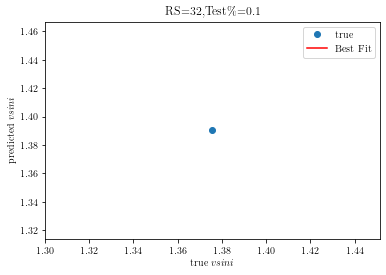

C:\Users\Jude\anaconda3\lib\site-packages\scipy\stats\_stats_mstats_common.py:130: RuntimeWarning: invalid value encountered in double_scalars
  slope = r_num / ssxm
C:\Users\Jude\anaconda3\lib\site-packages\scipy\stats\_stats_mstats_common.py:140: RuntimeWarning: invalid value encountered in sqrt
  t = r * np.sqrt(df / ((1.0 - r + TINY)*(1.0 + r + TINY)))
C:\Users\Jude\anaconda3\lib\site-packages\scipy\stats\_stats_mstats_common.py:142: RuntimeWarning: invalid value encountered in double_scalars
  sterrest = np.sqrt((1 - r**2) * ssym / ssxm / df)


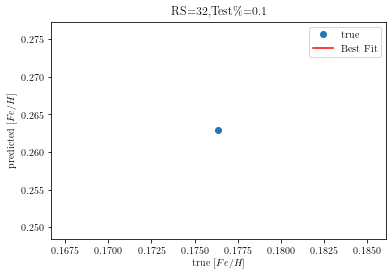

In [3]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
from TheCannon import model
from TheCannon import dataset
import TheCannon
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from scipy import stats
### wl
wl = np.genfromtxt("interpolated_wl.csv",skip_header=1)[::-1]

ID_and_flux = np.load("fluxes_for_HIRES.npy")
ivar = np.load("ivars_for_HIRES.npy")

#tr_ID
tr_ID = np.load("stellar_names_for_flux_and_ivar.npy",allow_pickle=True)
# #tr_flux
tr_flux = ID_and_flux.transpose()
#tr_ivar
tr_ivar = ivar.T
#Telluric (If you want to use the telluric mask add the path otherwise, set to False)
telluric_q = False #'../Constants/Masks/telluric_mask.txt'
#Iodine Mask (If you want to use the telluric mask add the path otherwise, set to False)
iodine_q = "../Constants/Masks/by_eye_iodine_mask.npy" 

#REAL WORK STARTS BELOW
# tr_label
#'[C/H]','[N/H]','[O/H]','[Na/H]','[Mg/H]','[Ai/H]','[Si/H]','[Ca/H]','[Ti/H]','[V/H]',
labels = ['T_{eff}', 'log g','vsini','[Fe/H]'] #Labels you want to use
d = pd.read_csv("../spocData/df_all.csv", index_col=2)
for c in ["Unnamed: 0","Unnamed: 0.1",'CH','NH','OH','NaH','MgH','AlH','SiH',
          'CaH','TiH','VH','CrH','MnH','NiH','YH','DIR']: #Labels you don't want to use need to be taken out
    d.pop(c)

testing_percentage = 0.10
#Random seed to check
random_seed_start = 32
random_seed_end = 33
#***You shouldn't have to change anything beyond this point
    
for i in range(22,40):
    d.pop("Unnamed: {}".format(i))

tr_label = d.to_numpy()

removeList = []
for i in d.index:
    test = i.replace(" ","")
    if test not in tr_ID:
        removeList.append(i)
for name in removeList:
    d = d.drop(name)  
    
    
index_d = d.index
index_d = np.array([i.replace(" ","") for i in index_d])
length_d = len(index_d)
restruc = []
array_d = d.to_numpy()
checking_index = 0
for i in range(len(tr_ID)):
    temp_ID = tr_ID[i-checking_index]
    loc = np.where(index_d == temp_ID)
    
    temp_list = []
    for l in array_d[loc]:
        for j in l:
            temp_list.append(float(j))
    if len(temp_list) == 0:
        tr_ID = np.delete(tr_ID,i-checking_index)
        tr_flux = np.delete(tr_flux,i-checking_index,0)
        tr_ivar = np.delete(tr_ivar,i-checking_index,0)
        checking_index+=1 
    else:
        restruc.append(temp_list)
tr_label = np.array(restruc)


if telluric_q: 
#     t = []
    telluric = np.genfromtxt(telluric_q)
#     for i in range(len(tr_flux)):
#         t.append(tr_flux[i] * telluric)
#     t = np.array(t)
#     tr_flux = t 
    tr_flux *= telluric
    tr_ivar *= telluric
if iodine_q:
    iodine_mask = np.load(iodine_q)
    tr_flux *= iodine_mask
    tr_ivar *= iodine_mask
    

t1, t2, t3, t4 = tr_ID, tr_flux,tr_ivar,tr_label
 
for RS in range(random_seed_start,random_seed_end):
    #RS = randseed #Random Seed # 
    tr_ID, tr_flux,tr_ivar,tr_label = t1, t2, t3, t4
    
    np.random.seed(RS)
    train_ID, test_ID, tr_flux, test_flux = train_test_split(tr_ID, tr_flux, test_size = testing_percentage)
    np.random.seed(RS)
    tr_ID2, _, tr_ivar, test_ivar = train_test_split(tr_ID, tr_ivar, test_size = testing_percentage)
    np.random.seed(RS)
    tr_ID, _, tr_label, true_test_labels = train_test_split(tr_ID, tr_label, test_size = testing_percentage)

    ds = dataset.Dataset(wl, tr_ID, tr_flux, tr_ivar, tr_label, test_ID, test_flux, test_ivar)

    
    ds.set_label_names(labels)

    ds.ranges= [[min(wl),max(wl)]]

    md = model.CannonModel(1, useErrors=False)
    md.fit(ds)


    md.diagnostics_leading_coeffs(ds)
    md.diagnostics_plot_chisq(ds)
    label_errs = md.infer_labels(ds)
    Cannon_test_labels = ds.test_label_vals
    #Mean-Squared Error 
    good_for_reports = True 
    for lab in ['T_{eff}', 'log g','vsini','[Fe/H]']:
        if lab not in labels:
            good_for_reports = False
    if good_for_reports:
        results_log = pd.read_csv("TheCannonReports.csv")
        results = {"# of Stars":len(tr_ID) + len(test_ID), 
                   "test %" :testing_percentage *100, 
                   "Seed #":RS,
                   "Telluric": telluric_q,
                   "MSE T_{eff}":float('-inf'),
                   "MSE log g":float('-inf'),
                  "MSE vsini":float('-inf'),
                  "MSE [Fe/H]":float('-inf'),
                  "Notes": "NA"}
        for i in range(len(labels)):
            results["MSE " + labels[i]] = mean_squared_error(true_test_labels[:,i],Cannon_test_labels[:,i])

        results_log = results_log.append(results,ignore_index=True)
        results_log.to_csv("TheCannonReports.csv",index=False)
    def MakeTrueVsPredictedPlots(true_label_vals,predicted_label_vals,col_num,labels):
        '''

        '''
        x = true_label_vals[:,col_num]
        y = predicted_label_vals[:,col_num]
        res = stats.linregress(x, y)
        plt.plot(x, y, 'o', label='true')
        plt.plot(x, res.intercept + res.slope*x, 'r', label='Best Fit')
        plt.legend()
        plt.title(f"RS={RS},Test\%={testing_percentage}")
        plt.xlabel(f'true ${labels[col_num]}$')
        plt.ylabel(f'predicted ${labels[col_num]}$')
        temp_name_change = labels[col_num][1:-1].replace("/","")
        plt.savefig(f"Element_Pictures/{temp_name_change}.png")  
        plt.show()
    for i in range(len(labels)):
        MakeTrueVsPredictedPlots(true_test_labels,Cannon_test_labels,i,labels)

### Testing Cleaner Code Below ***Do not use code below***
---

In [ ]:
#Imports 
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import TheCannon

from sklearn.model_selection import train_test_split
from TheCannon import apogee
from TheCannon import model
from TheCannon import dataset

In [ ]:
#Things to change
random_seed_number = 32  #For np.random.seed
#If you don't want to use a telluric mask, simply make 
# the path == False 
telluric_mask_path = '../spocData/telluric_mask.txt' 
fluxes_path = 'fluxes_for_HIRES.csv'
ivars_path = 'ivar_for_HIRES.csv'
test_percent = 0.20 #testing % of data The Cannon will train on 
labels = ['T_{eff}', 'log g','vsini','[Fe/H]'] #Labels you wanna train on 

In [ ]:
#Loading Data 
wl = pd.read_csv("interpolated_wl.csv").to_numpy().T[0]
#-----
ID_and_flux = pd.read_csv(fluxes_path)
hires_ivar = pd.read_csv(ivars_path).to_numpy().T
hires_flux = ID_and_flux.transpose().to_numpy() 
hires_ID = ID_and_flux.columns.to_numpy()
#-----Remove any unwanted Labels from SPOC data 
spoc = pd.read_csv("../spocData/df_all.csv", index_col=2)
for c in ["Unnamed: 0","Unnamed: 0.1",'CH','NH','OH','NaH','MgH','AlH','SiH',
          'CaH','TiH','VH','CrH','MnH','NiH','YH','DIR']:
    spoc.pop(c)
for i in range(22,40):
    spoc.pop("Unnamed: {}".format(i))
spoc_star_IDs = np.array([ID.replace(" ","") for ID in spoc.index])
spoc_star_label_values = spoc.to_numpy()
#-----

In [ ]:
wl = np.genfromtxt("interpolated_wl.csv",skip_header=1)[::-1]

ID_and_flux = pd.read_csv("fluxes_for_HIRES.csv")
ivar = pd.read_csv("ivar_for_HIRES.csv")
#tr_ID
ID = ID_and_flux.columns.to_numpy()  
# #tr_flux
tr_flux = ID_and_flux.transpose().to_numpy() 
tr_ID = ID_and_flux.columns.to_numpy()
#tr_ivar
tr_ivar = ivar.to_numpy().T
#-----

In [ ]:
# tr_label
d = pd.read_csv("../spocData/df_all.csv", index_col=2)
for c in ["Unnamed: 0","Unnamed: 0.1",'CH','NH','OH','NaH','MgH','AlH','SiH',
          'CaH','TiH','VH','CrH','MnH','NiH','YH','DIR']:
    d.pop(c)
for i in range(22,40):
    d.pop("Unnamed: {}".format(i))

tr_label = d.to_numpy()

In [ ]:
index_d = d.index
index_d = np.array([i.replace(" ","") for i in index_d])
length_d = len(index_d)
restruc = []
array_d = d.to_numpy()
checking_index = 0
for i in range(len(tr_ID)):
    temp_ID = tr_ID[i-checking_index]
    loc = np.where(index_d == temp_ID)
    
    temp_list = []
    for l in array_d[loc]:
        for j in l:
            temp_list.append(float(j))
    if len(temp_list) == 0:
        tr_ID = np.delete(tr_ID,i-checking_index)
        tr_flux = np.delete(tr_flux,i-checking_index,0)
        tr_ivar = np.delete(tr_ivar,i-checking_index,0)
        checking_index+=1 
    else:
        restruc.append(temp_list)
tr_label = np.array(restruc)

In [ ]:
#Removes stars that aren't in both the SPOC & HIRES data
labels,IDs,fluxes,ivars = [],[],[],[]
for index_hires in range(len(hires_ID)):
    id_hires = hires_ID[index_hires]
    index_spoc = np.where(id_hires == spoc_star_IDs)[0]
    if index_spoc.size > 0: #If the HIRES ID is in the spoc IDs 
        #Comes from HIRES
        fluxes.append(hires_flux[index_hires])
        IDs.append(hires_ID[index_hires])
        ivars.append(hires_ivar[index_hires])
        #Comes from SPOC 
        labels.append(spoc_star_label_values[index_spoc][0])
labels,IDs = np.array(labels),np.array(IDs)
fluxes,ivars = np.array(fluxes),np.array(ivars)

In [ ]:
#Telluric Mask
if telluric_mask_path:
    telluric_mask = np.genfromtxt(telluric_mask_path)
    fluxes *= telluric_mask   

In [ ]:
#Spliting the Data
np.random.seed(random_seed_number)
train_IDs,test_IDs,train_fluxes,test_fluxes = train_test_split(IDs, fluxes, test_size = test_percent)
np.random.seed(random_seed_number)
_,_,train_ivars,test_ivars = train_test_split(IDs, ivars, test_size = test_percent)
np.random.seed(random_seed_number)
_,_,train_labels,test_labels = train_test_split(IDs, labels, test_size = test_percent)

In [ ]:
#The Cannon Dataset class
ds = dataset.Dataset(wl, 
                     train_IDs, train_fluxes, train_ivars, train_labels,
                     test_IDs, test_fluxes, test_ivars)
#Setting the labels 
ds.set_label_names(labels)
#Plot SNR 
fig = ds.diagnostics_SNR() 
#Setting the range/s the of wavelengths The Cannon will use for training
ds.ranges= [[min(wl),max(wl)]]
#Begin training 
md = model.CannonModel(2, useErrors=False)
md.fit(ds)

In [ ]:
label_errs = md.infer_labels(ds)